### 1. Подготовка данных (Разделение: train.PurchDate < valid.PurchDate < test.PurchDate | Нормализация и преобразование)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.impute import SimpleImputer, KNNImputer
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/training.csv', index_col=0, parse_dates=['PurchDate'])
print(df.head(3))
print(df.info())

       IsBadBuy  PurchDate Auction  VehYear  VehicleAge   Make  \
RefId                                                            
1             0 2009-12-07   ADESA     2006           3  MAZDA   
2             0 2009-12-07   ADESA     2004           5  DODGE   
3             0 2009-12-07   ADESA     2005           4  DODGE   

                     Model Trim           SubModel   Color  ...  \
RefId                                                       ...   
1                   MAZDA3    i         4D SEDAN I     RED  ...   
2      1500 RAM PICKUP 2WD   ST  QUAD CAB 4.7L SLT   WHITE  ...   
3               STRATUS V6  SXT   4D SEDAN SXT FFV  MAROON  ...   

      MMRCurrentRetailAveragePrice  MMRCurrentRetailCleanPrice PRIMEUNIT  \
RefId                                                                      
1                          11597.0                     12409.0       NaN   
2                          11374.0                     12791.0       NaN   
3                           7

In [3]:
X = df.drop('IsBadBuy', axis=1)
y = df['IsBadBuy']

numeric_features = X.select_dtypes(include=['number'])
categorical_features = X.select_dtypes(include=['object'])

print(f'Count numeric: {len(numeric_features.columns.tolist())}')
print('Numeric features:', numeric_features.columns.tolist())
print(f'Count category: {len(categorical_features.columns.tolist())}')
print('Categorical features:', categorical_features.columns.tolist())

Count numeric: 17
Numeric features: ['VehYear', 'VehicleAge', 'WheelTypeID', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'BYRNO', 'VNZIP1', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']
Count category: 14
Categorical features: ['Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART', 'VNST']


In [4]:
# Разбиение по PurchDate
def split_df(df_split):
    sort_df = df_split.sort_values(by='PurchDate', ascending=True)

    train_end = int(len(sort_df) * 0.33)
    valid_end = int(len(sort_df) * 0.66)

    X = sort_df.drop('IsBadBuy', axis=1)
    y = sort_df['IsBadBuy']

    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_valid, y_valid = X.iloc[train_end:valid_end], y.iloc[train_end:valid_end]
    X_test, y_test = X.iloc[valid_end:], y.iloc[valid_end:]

    return X_train, X_valid, X_test, y_train, y_valid, y_test

# Визуальная проверка
def check_split_for_date(X_train, X_valid, X_test):
    print('Check split for date:')
    
    print('Train:')
    print(X_train['PurchDate'].min())
    print(X_train['PurchDate'].max())

    print('Valid:')
    print(X_valid['PurchDate'].min())
    print(X_valid['PurchDate'].max())

    print('Test:')
    print(X_test['PurchDate'].min())
    print(X_test['PurchDate'].max())


X_train, X_valid, X_test, y_train, y_valid, y_test = split_df(df)
print(X_train.iloc[:3, :3], y_train.iloc[:3], X_valid.iloc[:3, :3], y_valid.iloc[:3], X_test.iloc[:3, :3],
      y_test.iloc[:3], sep='\n\n', end='\n\n')
check_split_for_date(X_train, X_valid, X_test)

       PurchDate  Auction  VehYear
RefId                             
32389 2009-01-05  MANHEIM     2007
32406 2009-01-05  MANHEIM     2005
32407 2009-01-05  MANHEIM     2004

RefId
32389    0
32406    0
32407    0
Name: IsBadBuy, dtype: int64

       PurchDate  Auction  VehYear
RefId                             
44690 2009-09-11    OTHER     2007
44697 2009-09-11    OTHER     2006
5567  2009-09-11  MANHEIM     2004

RefId
44690    0
44697    0
5567     0
Name: IsBadBuy, dtype: int64

       PurchDate  Auction  VehYear
RefId                             
37502 2010-05-11  MANHEIM     2004
37501 2010-05-11  MANHEIM     2006
63599 2010-05-11  MANHEIM     2004

RefId
37502    0
37501    0
63599    0
Name: IsBadBuy, dtype: int64

Check split for date:
Train:
2009-01-05 00:00:00
2009-09-11 00:00:00
Valid:
2009-09-11 00:00:00
2010-05-11 00:00:00
Test:
2010-05-11 00:00:00
2010-12-30 00:00:00


In [5]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# ColumnTransformer - Совмещенный подход :)

# 1. Заполняем пропуски
preprocessor_fill = ColumnTransformer(
    transformers=[
        ('fill_null_category', SimpleImputer(strategy='constant', fill_value='missing'), categorical_features),
        ('fill_null_numeric', KNNImputer(n_neighbors=2, weights="uniform"), numerical_features),
    ]
)

X_train_filled = preprocessor_fill.fit_transform(X_train)
X_valid_filled = preprocessor_fill.transform(X_valid)
X_test_filled = preprocessor_fill.transform(X_test)

# 2. Кодируем категории и нормализуем числа
preprocessor_encoder = ColumnTransformer(
    transformers=[
        # Применяем OneHotEncoder к категориальным столбцам
        ('category', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        # Применяем StandardScaler к числовым столбцам
        ('numeric', MinMaxScaler(), numerical_features)
    ]
)

X_train_filled = pd.DataFrame(X_train_filled, columns=categorical_features + numerical_features)
X_valid_filled = pd.DataFrame(X_valid_filled, columns=categorical_features + numerical_features)
X_test_filled = pd.DataFrame(X_test_filled, columns=categorical_features + numerical_features)

X_train_transform = preprocessor_encoder.fit_transform(X_train_filled)
X_valid_transform = preprocessor_encoder.transform(X_valid_filled)
X_test_transform = preprocessor_encoder.transform(X_test_filled)

print(X_train_transform.shape)
print(X_train_transform)
# print(pd.DataFrame(X_train_transform).isnull().sum().sum())

(24084, 1712)
[[0.         1.         0.         ... 0.14887393 0.         0.13175099]
 [0.         1.         0.         ... 0.1354579  0.         0.06807845]
 [0.         1.         0.         ... 0.09345034 0.         0.09849346]
 ...
 [0.         0.         1.         ... 0.08795197 0.         0.08399659]
 [0.         0.         1.         ... 0.2419064  0.         0.07404775]
 [0.         0.         1.         ... 0.1253409  0.         0.28894258]]


### 2. Реализация MLP

#### Порядок обучения MLP

##### 1. Инициализация параметров
- Задаются:
  - Количество нейронов скрытого слоя
  - Функция активации
  - Learning rate
  - Число эпох
  - Размер батча
- Создаётся производная функции активации для обратного прохода.
- **Цель:** подготовить сеть к обучению и определить структуру нейронов.

##### 2. Инициализация весов и смещений
- Веса скрытого и выходного слоёв и смещения задаются случайными маленькими числами.
- **Цель:** нейроны начинают обучение с разных значений, чтобы сеть могла обучаться эффективно.

##### 3. Основной цикл по эпохам
- Для каждой эпохи:
  - Перемешиваются данные для случайного порядка примеров.
  - Разбиваются данные на батчи для более стабильного и быстрого обучения.

##### 4. Прямой проход
- **Скрытый слой:** вычисляется линейная комбинация входных признаков и весов, добавляется смещение.
- Применяется функция активации → получаем активность скрытого слоя.
- **Выходной слой:** линейное преобразование скрытого слоя → применяем сигмоиду → получаем вероятность класса 1.

##### 5. Вычисление потерь
- Используется Log Loss (кросс-энтропия).
- **Цель:** измерить, насколько сеть ошибается на текущем батче.

##### 6. Обратное распространение ошибки
- Вычисляется ошибка на выходе (разница между предсказанием и истинным классом).
- Распределяется ошибка на скрытый слой через веса и производную функции активации.
- Вычисляются градиенты для весов и смещений всех слоёв.
- **Цель:** понять, как скорректировать веса, чтобы уменьшить ошибку.

##### 7. Обновление весов
- Весы и смещения обновляются с помощью метода стохастического градиентного спуска (SGD).
- **Цель:** минимизировать функцию потерь, корректируя параметры сети.

##### 8. Повторение по батчам
- Для всех батчей текущей эпохи выполняются:
  - прямой проход
  - вычисление потерь
  - обратное распространение
  - обновление весов

##### 9. Повторение по всем эпохам
- Цикл по эпохам повторяется до конца обучения.
- Каждые несколько эпох обычно выводится текущее значение потерь для контроля обучения.

##### 10. Предсказание после обучения
- **predict_proba:** возвращает вероятность для классов 0 и 1.
- **predict:** возвращает предсказанный класс 0 или 1 по заданному порогу.

In [6]:
class MLP:
    # Конструктор класса
    def __init__(self, n_hidden=100, activation='tanh', lr=0.01, epochs=100, batch_size=32):
        self.n_hidden = n_hidden                 # Количество нейронов в скрытом слое
        self.activation = activation             # Функция активации для скрытого слоя
        self.lr = lr                             # Learning rate для обновления весов
        self.epochs = epochs                     # Количество эпох обучения
        self.batch_size = batch_size             # Размер батча для SGD

        # Определяем производную функции активации
        if activation == 'tanh':
            self.activation = np.tanh
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        elif activation == 'arctan':
            self.activation = np.arctan
            self.activation_deriv = lambda x: 1 / (1 + x**2)
        elif activation == 'relu':
            self.activation = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation = lambda x: 1 / (1 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation(x) * (1 - self.activation(x))
        elif activation == 'cos':
            self.activation = np.cos
            self.activation_deriv = lambda x: -np.sin(x)
        else:
            raise ValueError("Добавьте производную для вашей функции активации")

    @staticmethod
    def sigmoid(x):
        # Сигмоида для выходного слоя (вероятность)
        return 1 / (1 + np.exp(-x))

    # Метод обучения
    def fit(self, X, y):
        n_samples, n_features = X.shape  # Размерность данных: число примеров и признаков

        # Инициализация весов случайными малыми числами
        rng = np.random.default_rng(42)                                 # Генератор случайных чисел для воспроизводимости
        self.W1 = rng.normal(0, 0.01, size=(n_features, self.n_hidden)) # Веса между входом и скрытым слоем
        self.b1 = np.zeros((1, self.n_hidden))                          # Смещения скрытого слоя
        self.W2 = rng.normal(0, 0.01, size=(self.n_hidden, 1))          # Веса скрытого слоя → выход
        self.b2 = np.zeros((1, 1))                   # Смещение выходного нейрона

        y = y.reshape(-1, 1)                         # Преобразуем y в столбец

        # Основной цикл обучения по эпохам
        for epoch in range(self.epochs):
            indices = np.random.permutation(n_samples)       # Перемешиваем данные
            X_shuffled, y_shuffled = X[indices], y[indices]  # Перемешанные X и y

            # Обучение по батчам
            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]              # Выбираем батч входов
                y_batch = y_shuffled[start:end]              # Выбираем батч целевых значений

                # ===== Прямой проход =====
                Z1 = X_batch @ self.W1 + self.b1             # Линейное преобразование входа → скрытый слой
                A1 = self.activation(Z1)                     # Активация скрытого слоя
                Z2 = A1 @ self.W2 + self.b2                  # Линейное преобразование → выход
                y_pred = self.sigmoid(Z2)                    # Сигмоида → вероятность

                # ===== Потери =====
                # Log Loss (кросс-энтропия)
                loss = -np.mean(y_batch * np.log(y_pred + 1e-8) + 
                                (1 - y_batch) * np.log(1 - y_pred + 1e-8))

                # ===== Обратное распространение =====
                dZ2 = y_pred - y_batch                       # Ошибка на выходе
                dW2 = A1.T @ dZ2 / len(X_batch)              # Градиенты для W2
                db2 = np.mean(dZ2, axis=0, keepdims=True)    # Градиенты для b2

                dA1 = dZ2 @ self.W2.T                        # Распределение ошибки на скрытый слой
                dZ1 = dA1 * self.activation_deriv(Z1)        # Умножаем на производную активации
                dW1 = X_batch.T @ dZ1 / len(X_batch)         # Градиенты для W1
                db1 = np.mean(dZ1, axis=0, keepdims=True)    # Градиенты для b1

                # ===== Обновление весов (SGD) =====
                self.W1 -= self.lr * dW1                     # Обновление W1
                self.b1 -= self.lr * db1                     # Обновление b1
                self.W2 -= self.lr * dW2                     # Обновление W2
                self.b2 -= self.lr * db2                     # Обновление b2

            # Печать потерь каждые 10 эпох
            if (epoch + 1) % 10 == 0:
                print(f"Эпоха {epoch+1}/{self.epochs} — loss: {loss:.4f}")

    # Предсказание вероятностей
    def predict_proba(self, X):
        Z1 = X @ self.W1 + self.b1
        A1 = self.activation(Z1)
        Z2 = A1 @ self.W2 + self.b2
        y_pred = self.sigmoid(Z2)
        # Возвращаем массив [P(0), P(1)]
        return np.hstack([1 - y_pred, y_pred])

    # Предсказание классов
    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)[:, 1]              # Вероятность класса 1
        return (proba >= threshold).astype(int)          # Преобразуем в 0/1 по порогу

In [7]:
model = MLP(n_hidden=100, activation='arctan')
model.fit(X_train_transform, y_train.values)

Эпоха 10/100 — loss: 0.1762
Эпоха 20/100 — loss: 0.3156
Эпоха 30/100 — loss: 0.0922
Эпоха 40/100 — loss: 0.5712
Эпоха 50/100 — loss: 0.3542
Эпоха 60/100 — loss: 0.4078
Эпоха 70/100 — loss: 0.0958
Эпоха 80/100 — loss: 0.2302
Эпоха 90/100 — loss: 0.2323
Эпоха 100/100 — loss: 0.3421


### 3. Gini score

In [8]:
def gini_graph(y_true, y_score):
    auc = roc_auc_score(y_true, y_score)
    gini = 2 * auc - 1
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    plt.figure(figsize=(15, 8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color='g', label=f'AUC = {auc:.2f} (Gini = {gini:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate') 
    
def gini_score(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    gini = 2 * auc - 1
    print(f'Gini score: {gini:.4f}')
    return gini

Gini score: 0.4619


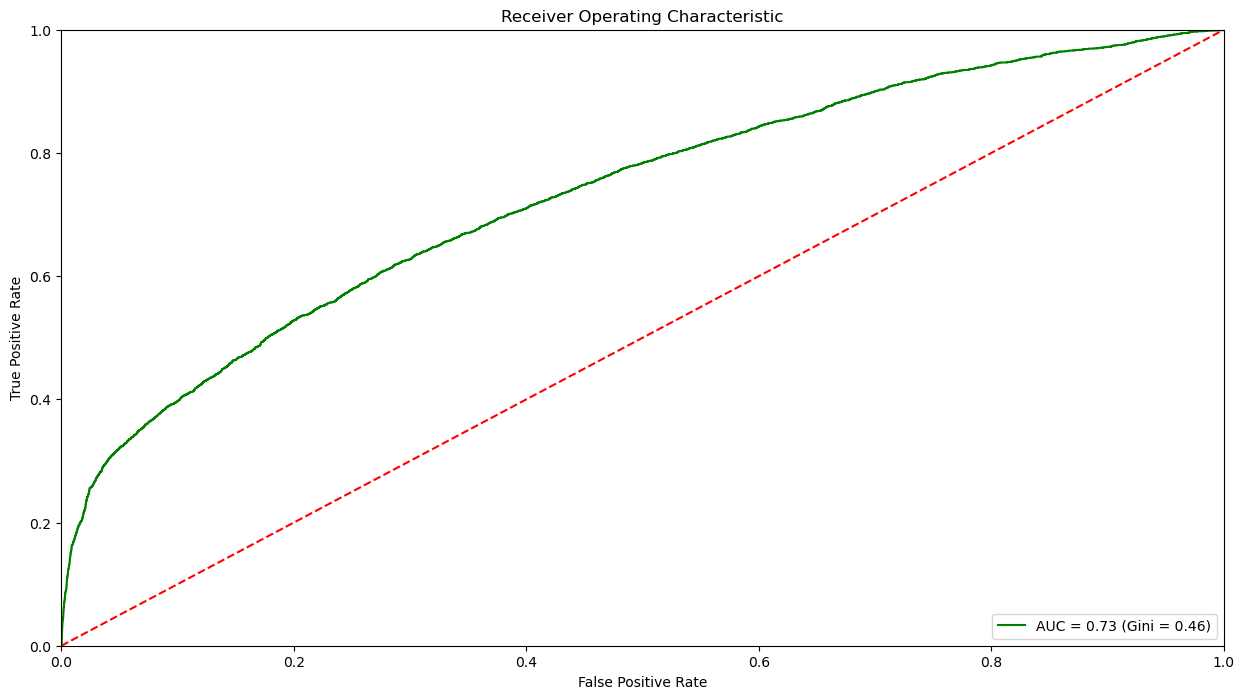

In [9]:
y_pred_proba = model.predict_proba(X_valid_transform)[:, 1]  # вероятность класса 1
gini = gini_score(y_valid, y_pred_proba)
gini_graph(y_valid, y_pred_proba)

### 4. MLPClassifier (sklearn)

In [10]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', batch_size=32,
                    solver='sgd', learning_rate_init=0.01, max_iter=100)

mlp.fit(X_train_transform, y_train.values)
print('MLPClassifier')

MLPClassifier


In [11]:
y_pred_proba = mlp.predict_proba(X_valid_transform)[:, 1]  # вероятность класса 1
gini_mlp = gini_score(y_valid, y_pred_proba)

Gini score: 0.4024


MLPClassifier иногда хуже по точности и медленнее, потому что выполняет дополнительные вычисления и проверки, тогда как чистая реализация делает только нужные матричные операции

### 5. Сравнение функций активации

In [12]:
func_activations = ['tanh', 'arctan', 'relu', 'sigmoid', 'cos']
result = pd.DataFrame(columns=['Activation', 'Gini'])

for activation in func_activations:
    print(f'MLP: {activation}')
    model_func = MLP(n_hidden=100, activation=activation)
    model_func.fit(X_train_transform, y_train.values.ravel())
    
    y_pred_proba = model_func.predict_proba(X_valid_transform)[:, 1]
    gini = gini_score(y_valid, y_pred_proba)
    
    current_df = pd.DataFrame({
        'Activation': [activation],
        'Gini': [gini]
    })
    result = pd.concat([result, current_df], ignore_index=True)

MLP: tanh
Эпоха 10/100 — loss: 0.4780
Эпоха 20/100 — loss: 0.0784
Эпоха 30/100 — loss: 0.2603
Эпоха 40/100 — loss: 0.0891
Эпоха 50/100 — loss: 0.2883
Эпоха 60/100 — loss: 0.2057
Эпоха 70/100 — loss: 0.3010
Эпоха 80/100 — loss: 0.4687
Эпоха 90/100 — loss: 0.2627
Эпоха 100/100 — loss: 0.2801
Gini score: 0.4615
MLP: arctan
Эпоха 10/100 — loss: 0.3524
Эпоха 20/100 — loss: 0.2012
Эпоха 30/100 — loss: 0.0920
Эпоха 40/100 — loss: 0.1136
Эпоха 50/100 — loss: 0.2779
Эпоха 60/100 — loss: 0.3887
Эпоха 70/100 — loss: 0.1915
Эпоха 80/100 — loss: 0.2649
Эпоха 90/100 — loss: 0.1330
Эпоха 100/100 — loss: 0.6164
Gini score: 0.4625
MLP: relu
Эпоха 10/100 — loss: 0.1043
Эпоха 20/100 — loss: 0.2241
Эпоха 30/100 — loss: 0.4971
Эпоха 40/100 — loss: 0.4376
Эпоха 50/100 — loss: 0.1620
Эпоха 60/100 — loss: 0.4354
Эпоха 70/100 — loss: 0.4907
Эпоха 80/100 — loss: 0.2675
Эпоха 90/100 — loss: 0.1212
Эпоха 100/100 — loss: 0.2723
Gini score: 0.4690
MLP: sigmoid
Эпоха 10/100 — loss: 0.3254
Эпоха 20/100 — loss: 0.1203

**Функции активации Sigmoid и ReLU показывают лучшие результаты**

### 6. Реализация MLP (Pytorch | Keras)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# Создаем модель
model_keras = Sequential()
# Добавляем скрытый слой
model_keras.add(Dense(100, input_dim=X_train_transform.shape[1], activation='tanh'))
# Добавляем выходной слой
model_keras.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model_keras.compile(optimizer=SGD(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

# Обучение
history = model_keras.fit(X_train_transform, y_train.values.ravel(),
                    validation_data=(X_valid_transform, y_valid.values.ravel()),
                    epochs=100,
                    batch_size=32,
                    verbose=2)

Epoch 1/100
753/753 - 4s - 5ms/step - AUC: 0.6229 - loss: 0.3519 - val_AUC: 0.6858 - val_loss: 0.3672
Epoch 2/100
753/753 - 2s - 3ms/step - AUC: 0.7095 - loss: 0.3266 - val_AUC: 0.7068 - val_loss: 0.3549
Epoch 3/100
753/753 - 3s - 4ms/step - AUC: 0.7277 - loss: 0.3145 - val_AUC: 0.7172 - val_loss: 0.3459
Epoch 4/100
753/753 - 2s - 3ms/step - AUC: 0.7373 - loss: 0.3067 - val_AUC: 0.7234 - val_loss: 0.3411
Epoch 5/100
753/753 - 2s - 3ms/step - AUC: 0.7445 - loss: 0.3020 - val_AUC: 0.7270 - val_loss: 0.3373
Epoch 6/100
753/753 - 2s - 3ms/step - AUC: 0.7478 - loss: 0.2993 - val_AUC: 0.7295 - val_loss: 0.3395
Epoch 7/100
753/753 - 2s - 3ms/step - AUC: 0.7507 - loss: 0.2978 - val_AUC: 0.7317 - val_loss: 0.3399
Epoch 8/100
753/753 - 2s - 3ms/step - AUC: 0.7539 - loss: 0.2966 - val_AUC: 0.7329 - val_loss: 0.3385
Epoch 9/100
753/753 - 2s - 3ms/step - AUC: 0.7555 - loss: 0.2960 - val_AUC: 0.7333 - val_loss: 0.3395
Epoch 10/100
753/753 - 2s - 3ms/step - AUC: 0.7574 - loss: 0.2954 - val_AUC: 0.734

In [14]:
y_pred_proba = model_keras.predict(X_valid_transform) # Вероятности класса 1
y_pred_class = (y_pred_proba >= 0.5).astype(int) # Классы (по порогу 0.5)
gini_keras = gini_score(y_valid, y_pred_proba)

753/753 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Gini score: 0.4583


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

# Преобразуем данные в тензоры
X_train_tensor = torch.tensor(X_train_transform, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.ravel(), dtype=torch.float32).unsqueeze(1)
X_valid_tensor = torch.tensor(X_valid_transform, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values.ravel(), dtype=torch.float32).unsqueeze(1)

# Простая модель через Sequential
model = nn.Sequential(
    nn.Linear(X_train_transform.shape[1], 100),
    nn.Tanh(),
    nn.Linear(100, 1),
    nn.Sigmoid()
)

# Оптимизатор и функция потерь
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

# Обучение
epochs = 100
batch_size = 32
n_samples = X_train_tensor.shape[0]

for epoch in range(epochs):                      # Цикл по эпохам (полные проходы по обучающей выборке)
    perm = torch.randperm(n_samples)             # Случайная перестановка индексов — для перемешивания данных перед каждой эпохой
    
    # Движемся по данным с шагом batch_size (мини-батчами)
    for i in range(0, n_samples, batch_size):
        idx = perm[i:i+batch_size]               # Берём индексы текущего батча
        X_batch, y_batch = X_train_tensor[idx], y_train_tensor[idx]  # Формируем батч входов и целевых значений

        optimizer.zero_grad()                    # Обнуляем градиенты (иначе они будут накапливаться)
        y_pred = model(X_batch)                  # Прямое распространение (forward pass) — вычисляем предсказания модели
        loss = criterion(y_pred, y_batch)        # Вычисляем ошибку (функция потерь)
        loss.backward()                          # Обратное распространение — считаем градиенты по всем параметрам
        optimizer.step()                         # Шаг оптимизации — обновляем веса модели на основе вычисленных градиентов
    
    # Каждые 10 эпох выводим текущее значение функции потерь
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, loss: {loss.item():.4f}")

Epoch 10/100, loss: 0.3506
Epoch 20/100, loss: 0.1027
Epoch 30/100, loss: 0.2211
Epoch 40/100, loss: 0.2037
Epoch 50/100, loss: 0.4155
Epoch 60/100, loss: 0.4601
Epoch 70/100, loss: 0.6719
Epoch 80/100, loss: 0.2641
Epoch 90/100, loss: 0.2175
Epoch 100/100, loss: 0.2019


In [16]:
with torch.no_grad():
    y_pred_proba = model(X_valid_tensor).numpy()
    y_pred_class = (y_pred_proba >= 0.5).astype(int)

gini_score(y_valid, y_pred_proba)

Gini score: 0.4620


0.4619888884967971

### 7. Оценка эффективности модели

In [17]:
# Преобразуем данные в тензоры
X_train_tensor = torch.tensor(X_train_transform, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.ravel(), dtype=torch.float32).unsqueeze(1)
X_valid_tensor = torch.tensor(X_valid_transform, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values.ravel(), dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_transform, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.ravel(), dtype=torch.float32).unsqueeze(1)

In [18]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model_opt = nn.Sequential(
    nn.Linear(X_train_transform.shape[1], 100),
    nn.ReLU(),
    nn.Linear(100, 1),
    nn.Sigmoid()
)

optimizer = optim.SGD(model_opt.parameters(), lr=0.01)
criterion = nn.BCELoss()

epochs = 100
for epoch in range(epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        y_pred = model_opt(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, loss: {loss.item():.4f}")

Epoch 10/100, loss: 0.4099
Epoch 20/100, loss: 0.6194
Epoch 30/100, loss: 0.1598
Epoch 40/100, loss: 0.2184
Epoch 50/100, loss: 0.3934
Epoch 60/100, loss: 0.3157
Epoch 70/100, loss: 0.0798
Epoch 80/100, loss: 0.1939
Epoch 90/100, loss: 0.3405
Epoch 100/100, loss: 0.1519


In [19]:
def print_metrics(model_pytorch):
    with torch.no_grad():
        print('----- Train -----')
        y_pred_proba_train = model_pytorch(X_train_tensor).numpy()
        gini_score(y_train, y_pred_proba_train)
        print('----- Valid -----')
        y_pred_proba_valid = model_pytorch(X_valid_tensor).numpy()
        gini_score(y_valid, y_pred_proba_valid)
        print('----- Test -----')
        y_pred_proba_test = model_pytorch(X_test_tensor).numpy()
        gini_score(y_test, y_pred_proba_test)
    
print_metrics(model_opt)

----- Train -----
Gini score: 0.6070
----- Valid -----
Gini score: 0.4712
----- Test -----
Gini score: 0.4045


Небольшое переобучение есть (Train > Valid > Test), оптимизируем :)

### 8. Бонус (Adam) - Оптимизация

In [20]:
model_adam = nn.Sequential(
    nn.Linear(X_train_transform.shape[1], 100),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(100, 1),
    nn.Sigmoid()
)

optimizer = optim.Adam(model_adam.parameters(), lr=0.0001)

epochs = 100
patience = 10 
best_gini = -np.inf
trigger_times = 0
best_model_state = {}

for epoch in range(epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        y_pred = model_adam(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
                
    if (epoch + 1) % 10 == 0:
        print(f"*** Epoch {epoch+1}/{epochs}, loss: {loss.item():.4f} ***")
        
    with torch.no_grad():
        y_valid_pred = model_adam(X_valid_tensor).numpy()
        current_gini = gini_score(y_valid, y_valid_pred)
    
    print(f"Epoch {epoch+1}, Validation Gini: {current_gini:.4f}")
    
     # Логика ранней остановки
    if current_gini > best_gini:
        best_gini = current_gini
        trigger_times = 0
        best_model_state = model_adam.state_dict()  # сохраняем лучшие веса
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping на эпохе {epoch+1}")
            model_adam.load_state_dict(best_model_state)  # загружаем лучшие веса
            break

Gini score: 0.3174
Epoch 1, Validation Gini: 0.3174
Gini score: 0.4004
Epoch 2, Validation Gini: 0.4004
Gini score: 0.4234
Epoch 3, Validation Gini: 0.4234
Gini score: 0.4344
Epoch 4, Validation Gini: 0.4344
Gini score: 0.4379
Epoch 5, Validation Gini: 0.4379
Gini score: 0.4390
Epoch 6, Validation Gini: 0.4390
Gini score: 0.4512
Epoch 7, Validation Gini: 0.4512
Gini score: 0.4465
Epoch 8, Validation Gini: 0.4465
Gini score: 0.4407
Epoch 9, Validation Gini: 0.4407
*** Epoch 10/100, loss: 0.5936 ***
Gini score: 0.4469
Epoch 10, Validation Gini: 0.4469
Gini score: 0.4433
Epoch 11, Validation Gini: 0.4433
Gini score: 0.4419
Epoch 12, Validation Gini: 0.4419
Gini score: 0.4467
Epoch 13, Validation Gini: 0.4467
Gini score: 0.4413
Epoch 14, Validation Gini: 0.4413
Gini score: 0.4394
Epoch 15, Validation Gini: 0.4394
Gini score: 0.4358
Epoch 16, Validation Gini: 0.4358
Gini score: 0.4353
Epoch 17, Validation Gini: 0.4353
Early stopping на эпохе 17


In [21]:
print_metrics(model_adam)

----- Train -----
Gini score: 0.6174
----- Valid -----
Gini score: 0.4395
----- Test -----
Gini score: 0.4349


Модель стабильно работает на новых данных (Valid = Test)